In [144]:
import pandas as pd
import os
import numpy as np
from datasets import Dataset, load_metric
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, RobertaConfig
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [145]:
df = pd.read_csv("full_t.csv")

In [146]:
df = df[['text', 'labels']]
df = df.dropna()
df.head()

,text,labels
0,Zwei Jubiläen als Stresstest\n\ninterviewLento...,interview
1,"Leserbrief: ""Klimawandel oder Klimakrise""\n\n ...",interview
2,„Kaum eine Woche unter 80 Arbeitsstunden!“\n\n...,interview
3,„Check this out! This is paradise!“\n\nDer US-...,interview
4,„Es War eine extreme hochschaubahn“\n\n Der ...,interview


In [147]:
df['labels'].value_counts()

labels
NONRELEVANT    169823
letter           4050
interview        1889
comment           629
Name: count, dtype: int64

<Axes: ylabel='count'>

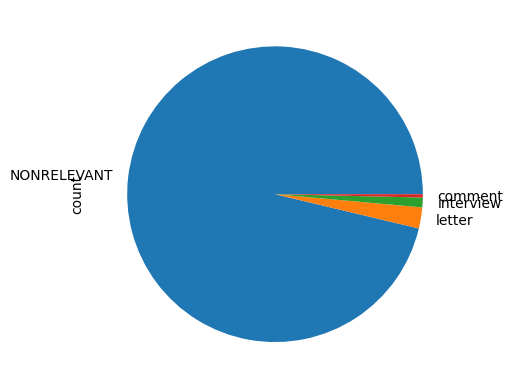

In [148]:
df['labels'].value_counts().plot(kind='pie')

<Axes: ylabel='count'>

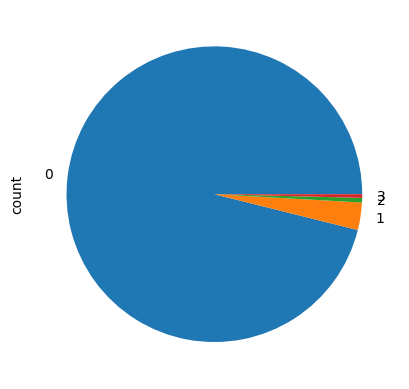

In [149]:

label_mapping = {"NONRELEVANT": 0, "letter": 1, 'interview': 2, 'comment': 3}
df['label'] = df['labels'].map(label_mapping)

train_df = df.groupby('labels').apply(lambda x: x.sample(n=2000, replace=True)).reset_index(drop=True)
train_indices = train_df.index

df_remaining = df.drop(train_indices)
val_df = df_remaining.sample(1000)
val_df['label'].value_counts().plot(kind='pie')

In [150]:
len(val_df), len(train_df)

(1000, 8000)

In [151]:
tokenizer = AutoTokenizer.from_pretrained("vikram71198/distilroberta-base-finetuned-fake-news-detection")
new_config = RobertaConfig.from_pretrained("vikram71198/distilroberta-base-finetuned-fake-news-detection", num_labels=4)

# Load the model with the new configuration and ignore mismatched sizes
model = AutoModelForSequenceClassification.from_pretrained("vikram71198/distilroberta-base-finetuned-fake-news-detection", config=new_config, ignore_mismatched_sizes=True)

model.to(device)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vikram71198/distilroberta-base-finetuned-fake-news-detection and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [152]:
train_df, test_df = train_test_split(train_df, test_size=0.2)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

# Tokenize the datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

accuracy_metric = load_metric("accuracy")
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy_metric.compute(predictions=preds, references=p.label_ids)

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [153]:
from transformers import Trainer, TrainingArguments
torch.cuda.empty_cache()
# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.048904,0.630000
2,No log,0.650278,0.796250
3,No log,0.412251,0.867500
4,No log,0.294426,0.911250
5,No log,0.253183,0.923125
6,No log,0.235424,0.928125
7,No log,0.249325,0.923125
8,No log,0.201366,0.940000
9,No log,0.183866,0.946875
10,No log,0.177538,0.948750


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=260, training_loss=0.27330116858849157, metrics={'train_runtime': 293.0192, 'train_samples_per_second': 436.831, 'train_steps_per_second': 0.887, 'total_flos': 1.6956431794176e+16, 'train_loss': 0.27330116858849157, 'epoch': 20.0})

In [154]:
model.save_pretrained('./apa-model')
tokenizer.save_pretrained('./apa-tokenizer')

('./apa-tokenizer/tokenizer_config.json',
 './apa-tokenizer/special_tokens_map.json',
 './apa-tokenizer/vocab.json',
 './apa-tokenizer/merges.txt',
 './apa-tokenizer/added_tokens.json',
 './apa-tokenizer/tokenizer.json')

In [155]:
model_path = './apa-model'
tokenizer_path = './apa-tokenizer'

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [156]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
import torch.nn.functional as F

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("./apa-tokenizer")
model = AutoModelForSequenceClassification.from_pretrained("./apa-model")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to classify news in batches
def classify_news(texts):
    # Ensure texts is a list of strings
    if not isinstance(texts, list):
        texts = [texts]

    # Tokenize the texts with truncation and padding
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move inputs to the GPU if available
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Make predictions
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

    # Calculate probabilities using softmax
    probabilities = F.softmax(logits, dim=-1).cpu().numpy()

    return predictions, probabilities

# Example of using the function on a single text input
p, pro = classify_news(val_df['text'].iloc[0])
print(p, pro)

[0] [[0.97654724 0.00426006 0.00457102 0.01462176]]


In [157]:
preds=[]
for text in val_df['text'].values:
    p, pro = classify_news(text)
    preds.append(p[0])

In [158]:
print(classification_report(val_df['label'], preds))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93       961
           1       0.91      0.97      0.94        30
           2       0.05      1.00      0.10         5
           3       0.11      1.00      0.19         4

    accuracy                           0.88      1000
   macro avg       0.52      0.96      0.54      1000
weighted avg       0.99      0.88      0.93      1000



In [ ]:
full_data = pd.read_csv("full_t.csv")
